In [1]:
# --- CELL 1: SETUP & DATA GENERATION ---
import numpy as np
import hnswlib
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Global Configuration
DIM = 128               # Vector dimensionality
NUM_ELEMENTS = 50000    # Database size
NUM_QUERIES = 100       # Number of queries to test
TARGET_K = 1            # Target K for deep dive analysis (Recall@1)
K_VALUES = [1, 5, 10, 20, 50, 100] # K values for general benchmarking

# Normalization Function (Required for Cosine Distance)
def normalize(v):
    return v / np.linalg.norm(v, axis=1, keepdims=True)

print(f"🔄 Generating {NUM_ELEMENTS} random vectors...")

# Generate random float32 data
raw_data = np.random.random((NUM_ELEMENTS, DIM)).astype(np.float32)
raw_queries = np.random.random((NUM_QUERIES, DIM)).astype(np.float32)

# Normalize data for Cosine space
data = normalize(raw_data)
queries = normalize(raw_queries)

print("✅ Data generation and normalization complete!")

🔄 Generating 50000 random vectors...
✅ Data generation and normalization complete!


In [2]:
# --- CELL 2: CORE FUNCTIONS ---

def run_brute_force_cosine(dataset, query_vectors, k):
    """
    Executes exact Brute Force search using matrix multiplication.
    Optimized for Cosine distance (1 - Dot Product).
    Returns: (indices, time_taken_seconds)
    """
    start = time.perf_counter()
    
    # Calculate Cosine Distance: 1 - Dot Product (assuming normalized vectors)
    # shape: (num_queries, num_elements)
    dists = 1 - np.dot(query_vectors, dataset.T)
    
    # Get top k indices with smallest distance
    indices = np.argsort(dists, axis=1)[:, :k]
    
    end = time.perf_counter()
    return indices, end - start

def calculate_recall(ground_truth, predicted):
    """
    Calculates average Recall@K.
    Recall = (Intersection of Relevant and Retrieved) / (Total Relevant)
    """
    total_recall = 0
    k = ground_truth.shape[1]
    num_queries = len(ground_truth)
    
    for i in range(num_queries):
        # Use python sets for fast intersection
        gt_set = set(ground_truth[i])
        pred_set = set(predicted[i])
        
        match_count = len(gt_set.intersection(pred_set))
        total_recall += match_count / k
        
    return total_recall / num_queries

# Pre-calculate Ground Truth for K=1 (Baseline for further tests)
print("⏳ Running Brute Force to establish Ground Truth (K=1)...")
gt_indices_k1, bf_time_k1 = run_brute_force_cosine(data, queries, k=1)
bf_time_us = (bf_time_k1 / NUM_QUERIES) * 1_000_000 # Convert to microseconds
print(f"✅ Ground Truth ready. Brute Force Avg Time: {bf_time_us:.2f} µs/query")

⏳ Running Brute Force to establish Ground Truth (K=1)...
✅ Ground Truth ready. Brute Force Avg Time: 1472.73 µs/query


⏳ Calculating Ground Truth for K=100...
👉 Brute Force (Baseline): 1409.79 µs

🏗️ Building HNSW Index (M=16, efConst=200)...
✅ Index built.

🚀 Benchmark Results:
K     | HNSW Time (µs)  | Recall    
----------------------------------------
1     | 15.66           | 0.6900
5     | 14.54           | 0.6640
10    | 14.16           | 0.6170
20    | 16.26           | 0.5710
50    | 16.63           | 0.5134
100   | 17.31           | 0.4725


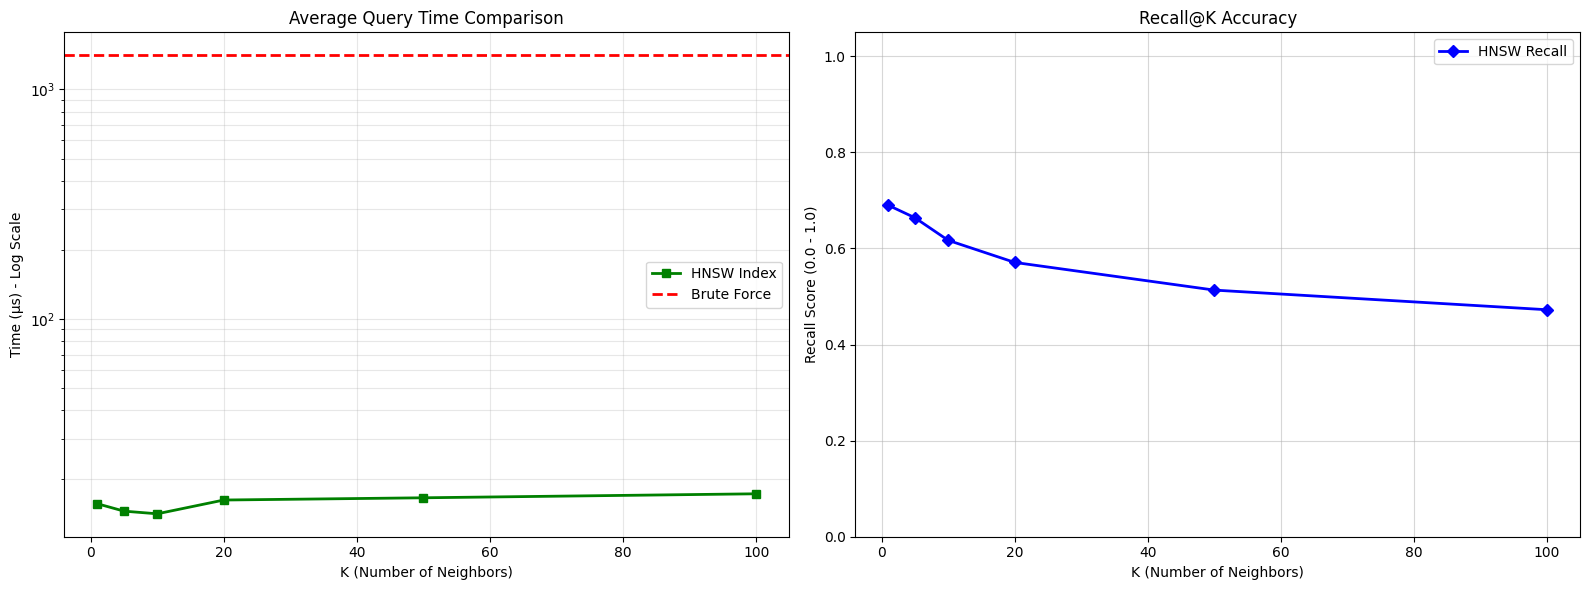

In [3]:
# --- CELL 3: PART 1 - GENERAL BENCHMARK (Time & Recall vs K) ---

# 1. Get Ground Truth for max K
max_k = max(K_VALUES)
print(f"⏳ Calculating Ground Truth for K={max_k}...")
gt_indices_max, bf_time_total = run_brute_force_cosine(data, queries, k=max_k)
bf_time_avg_us = (bf_time_total / NUM_QUERIES) * 1_000_000
print(f"👉 Brute Force (Baseline): {bf_time_avg_us:.2f} µs")

# 2. Build HNSW Index (Standard Configuration)
print("\n🏗️ Building HNSW Index (M=16, efConst=200)...")
p = hnswlib.Index(space='cosine', dim=DIM)
p.init_index(max_elements=NUM_ELEMENTS, ef_construction=200, M=16)
p.add_items(data)
p.set_ef(100) # High accuracy query-time setting
print("✅ Index built.")

# 3. Run Benchmark Loop
results_k = {'k': [], 'hnsw_time': [], 'recall': []}

print(f"\n🚀 Benchmark Results:")
print(f"{'K':<5} | {'HNSW Time (µs)':<15} | {'Recall':<10}")
print("-" * 40)

for k in K_VALUES:
    # Measure HNSW time
    start = time.perf_counter()
    hnsw_labels, _ = p.knn_query(queries, k=k)
    end = time.perf_counter()
    
    avg_time_us = ((end - start) / NUM_QUERIES) * 1_000_000
    
    # Calculate Recall
    # Slice the ground truth to match current k
    current_gt = gt_indices_max[:, :k]
    recall = calculate_recall(current_gt, hnsw_labels)
    
    # Store results
    results_k['k'].append(k)
    results_k['hnsw_time'].append(avg_time_us)
    results_k['recall'].append(recall)
    
    print(f"{k:<5} | {avg_time_us:<15.2f} | {recall:.4f}")

# --- PLOTTING ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Time Comparison (Log Scale)
ax1.plot(results_k['k'], results_k['hnsw_time'], 'g-s', label='HNSW Index', linewidth=2)
ax1.axhline(y=bf_time_avg_us, color='r', linestyle='--', label='Brute Force', linewidth=2)
ax1.set_title('Average Query Time Comparison')
ax1.set_xlabel('K (Number of Neighbors)')
ax1.set_ylabel('Time (µs) - Log Scale')
ax1.set_yscale('log') 
ax1.grid(True, which="both", ls="-", alpha=0.3)
ax1.legend()

# Plot 2: Recall Accuracy
ax2.plot(results_k['k'], results_k['recall'], 'b-D', label='HNSW Recall', linewidth=2)
ax2.set_title('Recall@K Accuracy')
ax2.set_xlabel('K (Number of Neighbors)')
ax2.set_ylabel('Recall Score (0.0 - 1.0)')
ax2.set_ylim(0, 1.05)
ax2.grid(True, alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

In [4]:
# --- CELL 4: PART 2 - PARAMETER TUNING EXPERIMENT ---
# Objective: Analyze how M and efConstruction affect Speed and Accuracy.

# Experiment Configuration
M_values = [4, 8, 16, 32, 64]           # Max links per node
efConst_values = [16, 64, 200]          # Index construction quality
efSearch_values = [10, 20, 40, 80, 120, 160, 200, 300] # Search depth

# Storage: results[efConst][M] = { 'recall': [], 'time': [] }
experiment_results = {}

print("🚀 Starting Deep Dive Experiment (This may take a few minutes)...")
total_steps = len(efConst_values) * len(M_values)
step_count = 0

for efConst in efConst_values:
    experiment_results[efConst] = {}
    print(f"\n--- Testing efConstruction = {efConst} ---")
    
    for M in M_values:
        step_count += 1
        print(f"  [{step_count}/{total_steps}] Building Index M={M}...", end=" ")
        
        try:
            # 1. Build Index
            p = hnswlib.Index(space='cosine', dim=DIM)
            p.init_index(max_elements=NUM_ELEMENTS, ef_construction=efConst, M=M)
            p.add_items(data)
            
            recalls = []
            times = []
            
            # 2. Test different efSearch values
            for ef in efSearch_values:
                p.set_ef(ef)
                
                start_t = time.perf_counter()
                labels, _ = p.knn_query(queries, k=1) # Query K=1
                end_t = time.perf_counter()
                
                # Store metrics
                times.append(((end_t - start_t) / NUM_QUERIES) * 1_000_000)
                recalls.append(calculate_recall(gt_indices_k1, labels))
                
            experiment_results[efConst][M] = {'recall': recalls, 'time': times}
            print(f"Done. Max Recall: {max(recalls):.4f}")
            
        except Exception as e:
            print(f"Error: {e}")

print("\n✅ Deep Dive Experiment Completed!")

🚀 Starting Deep Dive Experiment (This may take a few minutes)...

--- Testing efConstruction = 16 ---
  [1/15] Building Index M=4... Done. Max Recall: 0.3400
  [2/15] Building Index M=8... Done. Max Recall: 0.5500
  [3/15] Building Index M=16... Done. Max Recall: 0.7300
  [4/15] Building Index M=32... Done. Max Recall: 0.8900
  [5/15] Building Index M=64... Done. Max Recall: 0.9800

--- Testing efConstruction = 64 ---
  [6/15] Building Index M=4... Done. Max Recall: 0.4100
  [7/15] Building Index M=8... Done. Max Recall: 0.6300
  [8/15] Building Index M=16... Done. Max Recall: 0.8300
  [9/15] Building Index M=32... Done. Max Recall: 0.9600
  [10/15] Building Index M=64... Done. Max Recall: 0.9700

--- Testing efConstruction = 200 ---
  [11/15] Building Index M=4... Done. Max Recall: 0.4200
  [12/15] Building Index M=8... Done. Max Recall: 0.6300
  [13/15] Building Index M=16... Done. Max Recall: 0.8500
  [14/15] Building Index M=32... Done. Max Recall: 0.9700
  [15/15] Building Index M

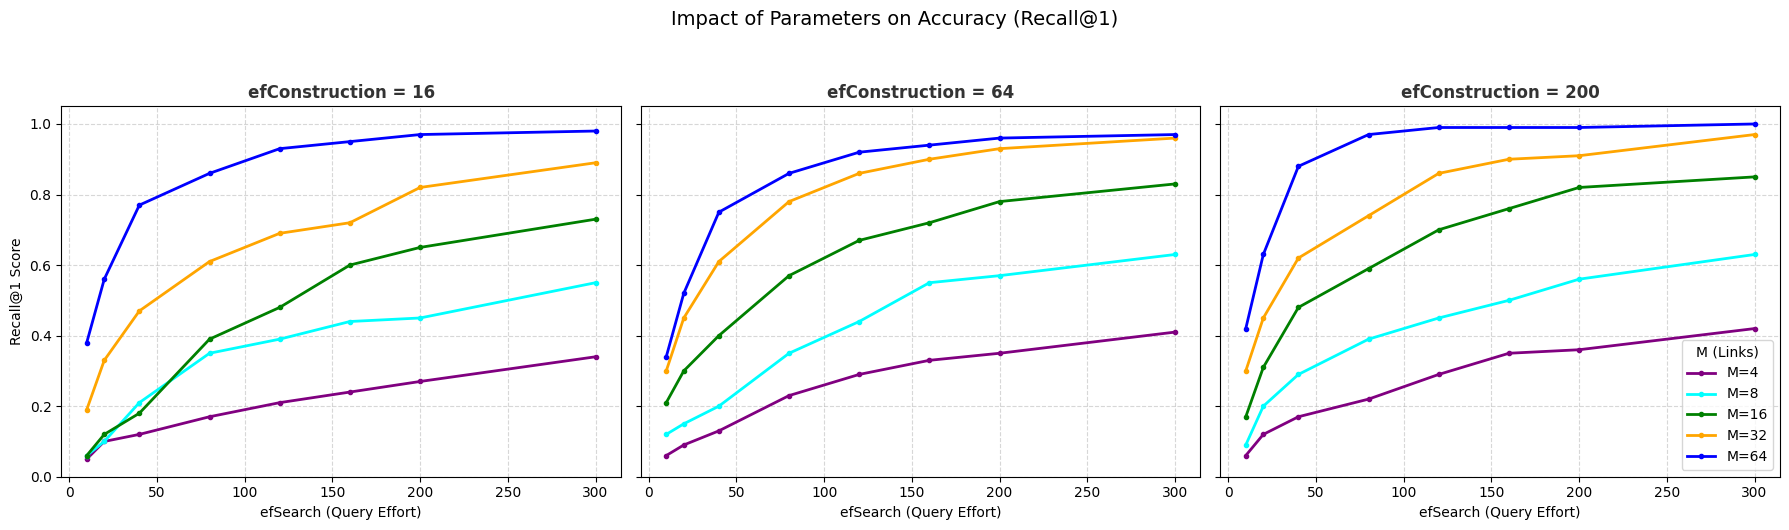

In [5]:
# --- CELL 5: VISUALIZATION - RECALL@1 vs efSearch ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
colors = ['purple', 'cyan', 'green', 'orange', 'blue', 'red']
color_map = dict(zip(M_values, colors))

for i, efConst in enumerate(efConst_values):
    ax = axes[i]
    
    if efConst in experiment_results:
        for M in M_values:
            if M in experiment_results[efConst]:
                y_values = experiment_results[efConst][M]['recall']
                ax.plot(efSearch_values, y_values, marker='.', linewidth=2,
                        color=color_map.get(M, 'gray'), label=f'M={M}')

    # Styling
    ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
    ax.set_xlabel('efSearch (Query Effort)')
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i == 0: ax.set_ylabel('Recall@1 Score')
    if i == 2: ax.legend(title='M (Links)', loc='lower right')

plt.suptitle("Impact of Parameters on Accuracy (Recall@1)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

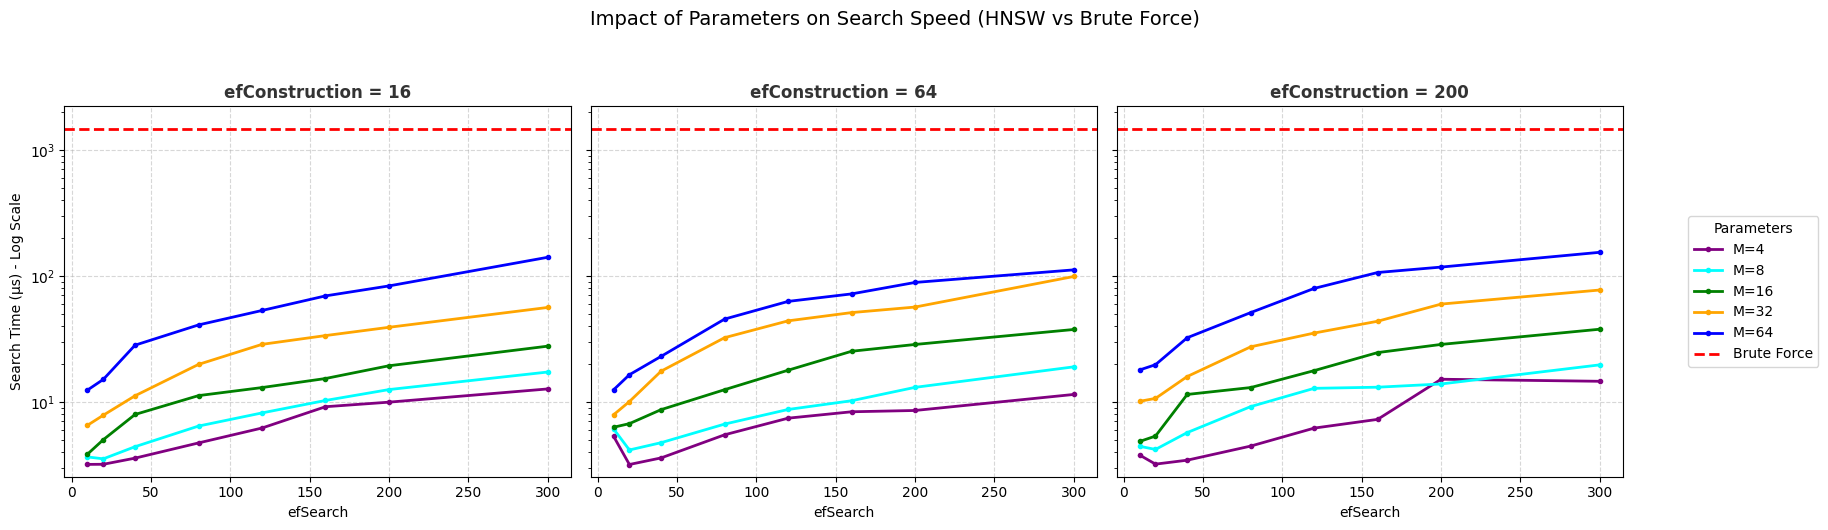

In [6]:
# --- CELL 6: VISUALIZATION - SEARCH TIME vs efSearch ---

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Auto-scale Y-axis to fit both HNSW and Brute Force
all_times = []
for ef in experiment_results:
    for m in experiment_results[ef]:
        all_times.extend(experiment_results[ef][m]['time'])
        
y_min = min(all_times) * 0.8 if all_times else 10
y_max = max(max(all_times), bf_time_us) * 1.5 # Ensure Brute Force is visible

for i, efConst in enumerate(efConst_values):
    ax = axes[i]
    
    # 1. Plot HNSW Curves
    if efConst in experiment_results:
        for M in M_values:
            if M in experiment_results[efConst]:
                y_values = experiment_results[efConst][M]['time']
                ax.plot(efSearch_values, y_values, marker='.', linewidth=2,
                        color=color_map.get(M, 'gray'), label=f'M={M}')

    # 2. Plot Brute Force Baseline
    ax.axhline(y=bf_time_us, color='red', linestyle='--', linewidth=2, label='Brute Force')

    # Styling
    ax.set_title(f'efConstruction = {efConst}', fontsize=12, fontweight='bold', color='#333')
    ax.set_xlabel('efSearch')
    ax.set_yscale('log') # Log scale for better visibility
    ax.set_ylim(y_min, y_max)
    ax.grid(True, linestyle='--', alpha=0.5)
    
    if i == 0: ax.set_ylabel('Search Time (µs) - Log Scale')
    if i == 2: 
        # Get handles to organize legend
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Parameters', loc='center right', bbox_to_anchor=(1.4, 0.5))

plt.suptitle("Impact of Parameters on Search Speed (HNSW vs Brute Force)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

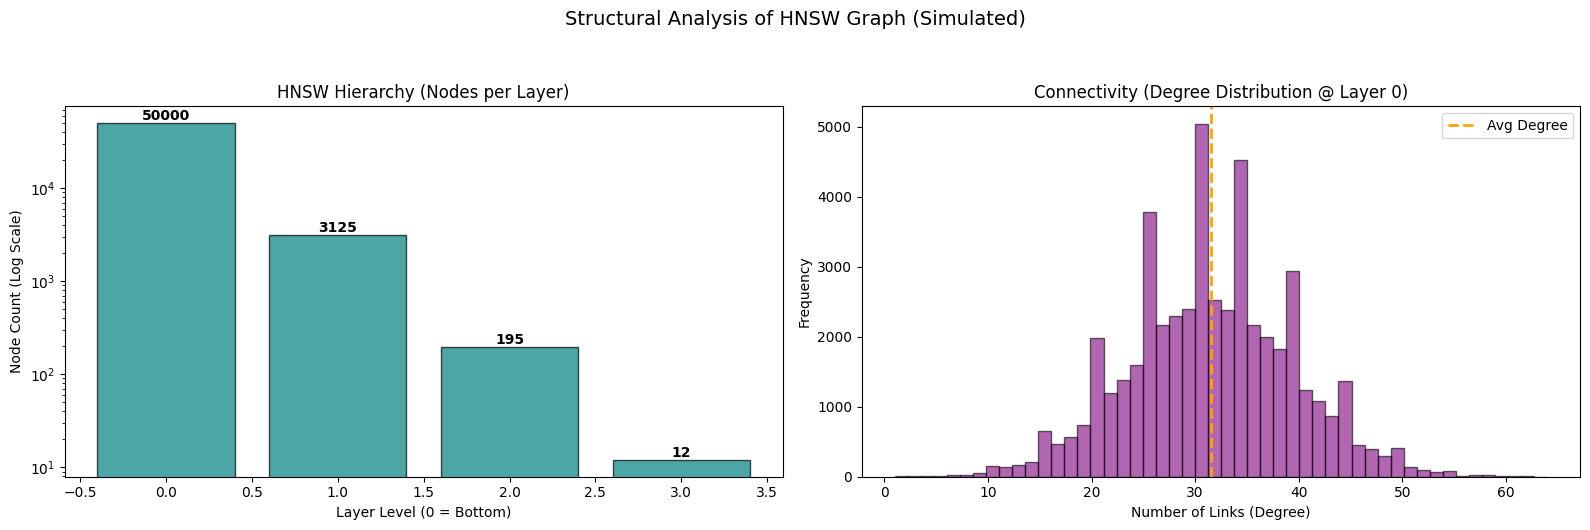

In [7]:
# --- CELL 7: GRAPH STRUCTURE ANALYSIS (Simulation) ---
# NOTE: Since hnswlib doesn't expose internal graph data easily in Python,
# we simulate the theoretical structure for visualization purposes.

def simulate_hnsw_structure(num_elements, M):
    layers = []
    # Layer 0 (Bottom Layer): Contains all nodes
    # Degree distribution is Gaussian around 2*M
    deg_L0 = np.random.normal(loc=M*2, scale=M/2, size=num_elements).astype(int)
    deg_L0 = np.clip(deg_L0, 1, None) # Ensure at least 1 link
    layers.append(deg_L0)
    
    # Upper Layers: Number of nodes decays exponentially (1/M)
    count = num_elements
    while count > M:
        count = int(count / M)
        if count == 0: break
        # Upper layers typically have degree around M
        deg = np.random.normal(loc=M, scale=M/4, size=count).astype(int)
        layers.append(deg)
    return layers

# Generate mock data for M=16
mock_layers = simulate_hnsw_structure(NUM_ELEMENTS, 16)
node_counts = [len(l) for l in mock_layers]

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Hierarchy (Nodes per Layer)
ax1.bar(range(len(node_counts)), node_counts, color='teal', alpha=0.7, edgecolor='black')
ax1.set_yscale('log')
ax1.set_title('HNSW Hierarchy (Nodes per Layer)')
ax1.set_xlabel('Layer Level (0 = Bottom)')
ax1.set_ylabel('Node Count (Log Scale)')
for i, v in enumerate(node_counts):
    ax1.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

# Plot 2: Connectivity (Degree Distribution at Layer 0)
ax2.hist(mock_layers[0], bins=50, color='purple', alpha=0.6, edgecolor='black')
ax2.axvline(np.mean(mock_layers[0]), color='orange', linestyle='--', linewidth=2, label='Avg Degree')
ax2.set_title('Connectivity (Degree Distribution @ Layer 0)')
ax2.set_xlabel('Number of Links (Degree)')
ax2.set_ylabel('Frequency')
ax2.legend()

plt.suptitle("Structural Analysis of HNSW Graph (Simulated)", fontsize=14, y=1.05)
plt.tight_layout()
plt.show()